# Download data from blob storage

In [ ]:
!pip install azure-storage-blob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 366 kB 8.0 MB/s 
     |████████████████████████████████| 178 kB 72.0 MB/s 
     |████████████████████████████████| 4.0 MB 63.2 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
     |████████████████████████████████| 41 kB 717 kB/s 


In [ ]:
import os
from azure.storage.blob import ContainerClient, __version__

key = "DefaultEndpointsProtocol=https;AccountName=del2984826843;AccountKey=kSYohscGrcofRDfc45qylMvhfgaXZt2H37ofNaUsZHHWhN695wArQWA0YfgQvxN9IlFOPI3OnKE70w5xsC7GXw==;EndpointSuffix=core.windows.net"

if "test.npz" not in os.listdir() and "train.npz" not in os.listdir():
    try:
        print("Azure Blob Storage v" + __version__)
        # Quick start code goes here
        cc = ContainerClient.from_connection_string(conn_str=key, container_name='data-fm-rs')

        with open("train.npz", "wb") as f:
            f.write(cc.download_blob('train.npz').content_as_bytes())
        with open("test.npz", "wb") as f:
            f.write(cc.download_blob('test.npz').content_as_bytes())

    except Exception as ex:
        print('Exception:')
        print(ex)

Azure Blob Storage v12.12.0


# Imports and basic settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import torch
import torchvision

In [2]:
# set cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set standart plot size to (21,10)
plt.rcParams['figure.figsize'] = (21, 10)

# Seed
seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cpu


# Dataloader

In [3]:
class activityData(torch.utils.data.Dataset):
    '''
    Class for activity data.
    '''
    def __init__(self, url:str):
        data = np.load(file=url, allow_pickle=False)
        self.x = torch.from_numpy(data['X'])
        self.y = torch.from_numpy(data['y'])
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [4]:
batchsize = 128

# create datasets and dataloaders
dataTrain = activityData(url='train.npz')
dataTest = activityData(url="test.npz")
loaderTrain = torch.utils.data.DataLoader(dataset=dataTrain, batch_size=batchsize, shuffle=True)
loaderTest = torch.utils.data.DataLoader(dataset=dataTest, batch_size=batchsize, shuffle=False)

# Define model of CNN

In [5]:
loaderTrain.dataset.x[0].shape, loaderTrain.dataset.y[0].shape

(torch.Size([43, 13]), torch.Size([]))

# Functions for training model

In [ ]:
def calcOutputDim(Input:int, kernel:int, padding:int, stride:int):
    '''
    Calculates output width of a convolutional layer.
    '''
    return int((Input - kernel + 2*padding)/stride + 1)

In [ ]:
def evalF1(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.unsqueeze(1).float()
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [ ]:
def train(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs - 10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [ ]:
def evalTest(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))

    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

In [ ]:
# confusion matrix
def confusionMatrix1D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix

# confusion matrix
def confusionMatrix2D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix


def plotConfusionMatrix(cm):
    labels = ['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring', 'Jogging', 'Stairway']
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # annotate n samples
    for i in range(7):
        for j in range(7):
            plt.text(j, i, int(cm[i, j].item()), horizontalalignment='center', verticalalignment='center')
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
# dictionary for storing results from different models
results = {}

# Model with 1 convolutional layer

In [ ]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()
        
        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            # torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            # activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=2944, out_features=1500),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1500),
            torch.nn.Linear(in_features=1500, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x

# define model without batchnorm
class CNN_NBN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN_NBN, self).__init__()
        
        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        
            # torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            # activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=2944, out_features=1500),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1500),
            torch.nn.Linear(in_features=1500, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 485.55267840623856
loss 324.08171275258064
loss 286.0696622133255
loss 257.95277556777
loss 243.80846865475178
loss 227.71254494786263
loss 209.4629953354597
loss 201.96893683075905
loss 201.40738201141357
loss 185.86144533753395
loss 178.26712629199028
loss 169.56842728704214
loss 160.70828934013844
loss 161.92372001707554
loss 157.05992133915424
loss 149.55645795166492
loss 152.6737654581666
loss 139.67789990454912
loss 135.4248120263219
loss 132.62869433313608
loss 126.09224794059992
loss 131.5348415747285
loss 129.80533535778522
loss 121.18114763498306
loss 113.06249922513962
loss 116.09871652722359
loss 112.34442853927612
loss 112.3382205888629
loss 106.60791021585464
loss 107.41886004805565
loss 100.14454061165452
loss 105.96616366133094
loss 103.4823297560215
loss 96.1448293812573
loss 98.35304266214371
loss 94.38514545932412
loss 89.88241029530764
loss 174.95563753694296
loss 99.9060164950788
loss 89.8071747906506
loss 86.51208975166082
loss 86.86056355386972
loss 85.70474

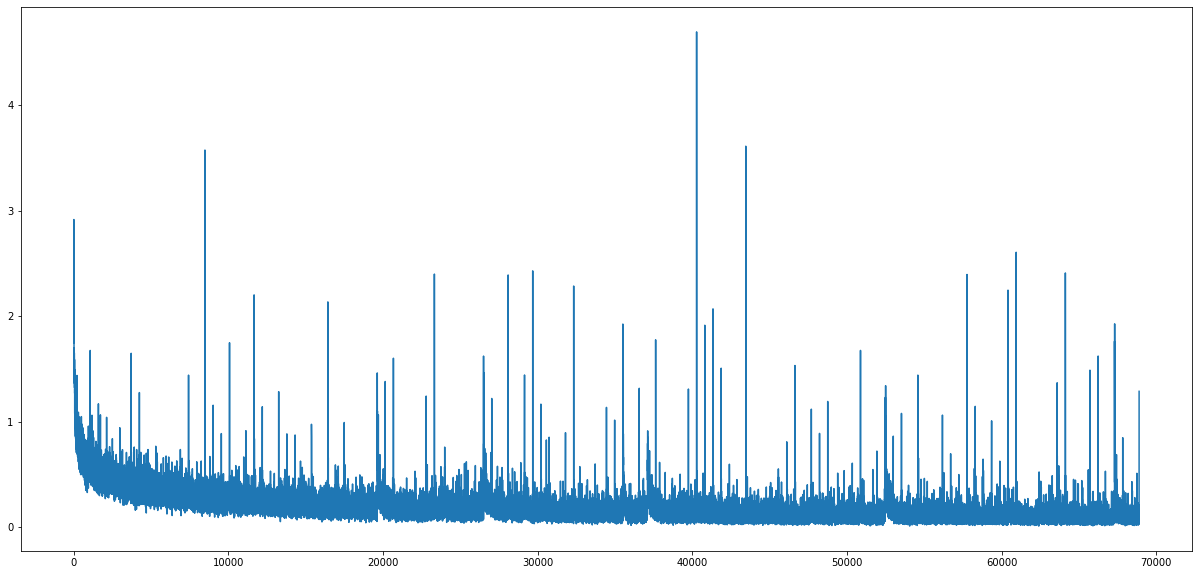

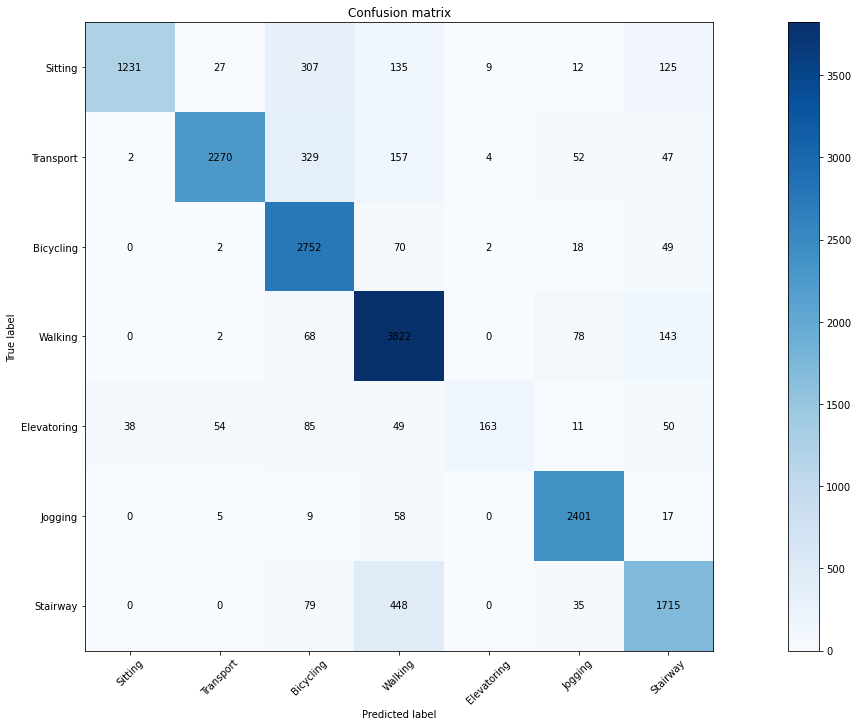

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_2d_1layer_bn.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_1layer_bn"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, "cm": cm}

loss 456.72358068823814
loss 302.05546820163727
loss 250.57084247469902
loss 214.7255653887987
loss 192.96780759096146
loss 183.6573937535286
loss 169.6195579469204
loss 196.04258731007576
loss 155.7107196599245
loss 142.98399445414543
loss 132.93186853826046
loss 123.80555767565966
loss 129.639046728611
loss 111.2270901426673
loss 136.18423371762037
loss 109.25650100409985
loss 96.54760740697384
loss 96.55710203200579
loss 112.80633525550365
loss 91.09247230738401
loss 91.30977847054601
loss 86.73389645293355
loss 85.86345899105072
loss 80.2173240184784
loss 79.91753173992038
loss 83.96194803714752
loss 73.73291690275073
loss 76.17742943018675
loss 65.79128193482757
loss 66.4326866902411
loss 64.51145554333925
loss 64.8087398018688
loss 63.19910474866629
loss 58.070850502699614
loss 58.06487484276295
loss 54.23841512016952
loss 51.78471782244742
loss 47.49894601665437
loss 55.87190912850201
loss 55.356681713834405
loss 61.17501417733729
loss 48.698787992820144
loss 51.94188261218369
l

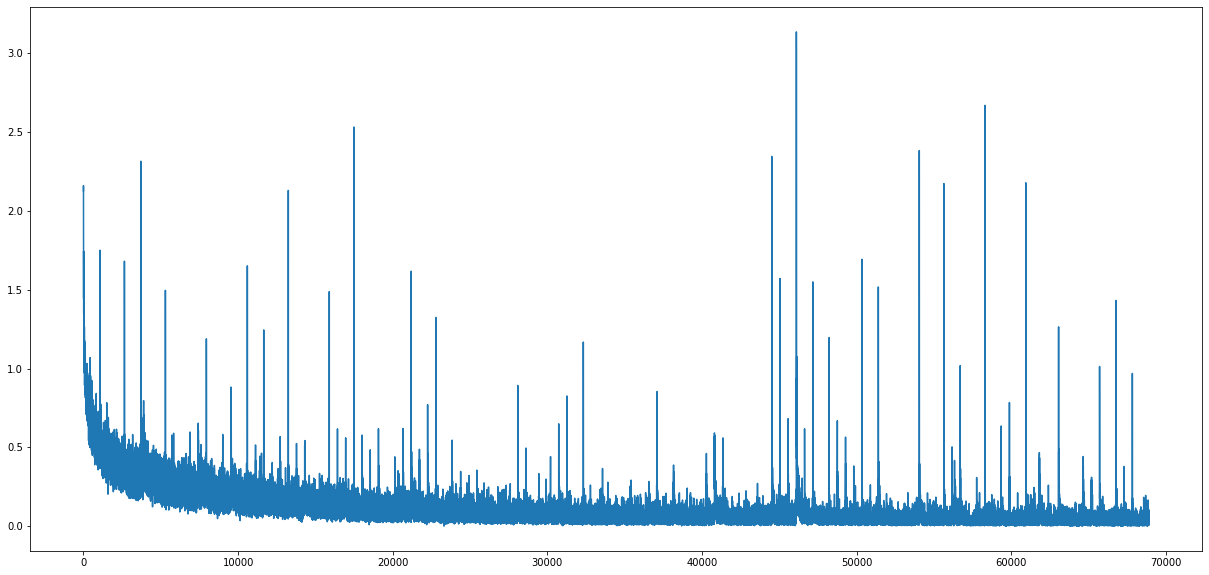

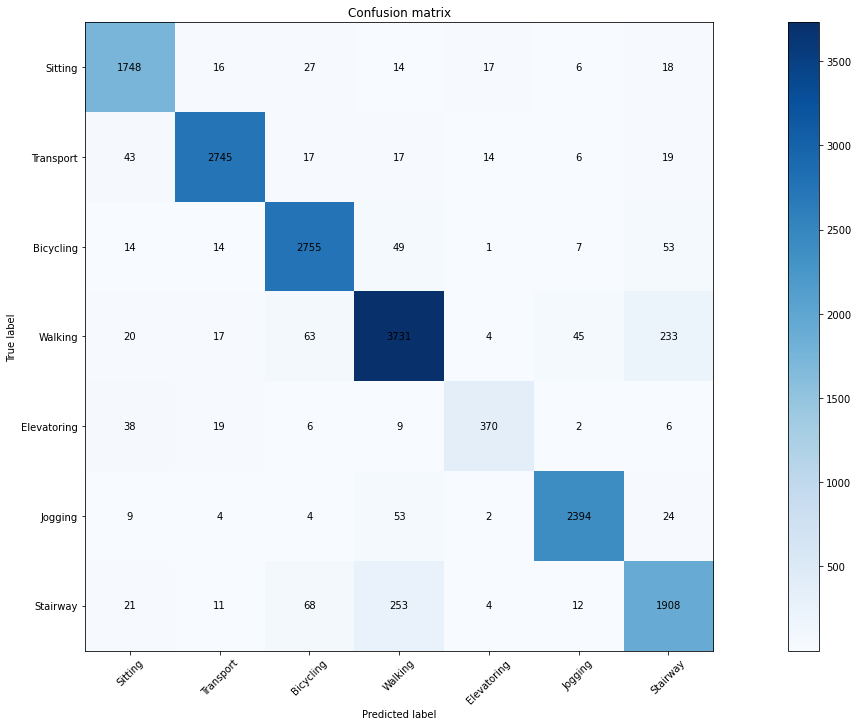

In [ ]:
model = CNN_NBN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_2d_2layer.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_1layer"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, 'cm': cm}

# Model with 2 convolutional layer

In [ ]:
# define model
class CNN_BN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN_BN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1920, out_features=1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1000),
            torch.nn.Linear(in_features=1000, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1920, out_features=1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1000),
            torch.nn.Linear(in_features=1000, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 463.03433924913406
loss 308.23866176605225
loss 277.8440630286932
loss 238.39294737577438
loss 215.45556885004044
loss 206.562987819314
loss 185.8145648241043
loss 172.20032942295074
loss 163.18763311207294
loss 198.24360136687756
loss 152.9200452491641
loss 147.36579240113497
loss 132.0291637480259
loss 125.99498913437128
loss 131.25581043213606
loss 119.37082279473543
loss 116.80129925906658
loss 116.69939635694027
loss 104.41744105517864
loss 103.88494899123907
loss 108.22964563965797
loss 101.00375876575708
loss 101.79635247215629
loss 89.0120656080544
loss 84.99058898165822
loss 81.55796365812421
loss 80.97186125069857
loss 84.92851534485817
loss 93.90132604539394
loss 75.5618169978261
loss 79.9124025143683
loss 69.2870108820498
loss 69.87176829949021
loss 156.31582863628864
loss 223.8307668119669
loss 118.55079886317253
loss 92.24412415921688
loss 80.00385780259967
loss 73.51979507505894
loss 69.07355725392699
loss 68.24914293177426
loss 66.09803412482142
loss 63.36591405421

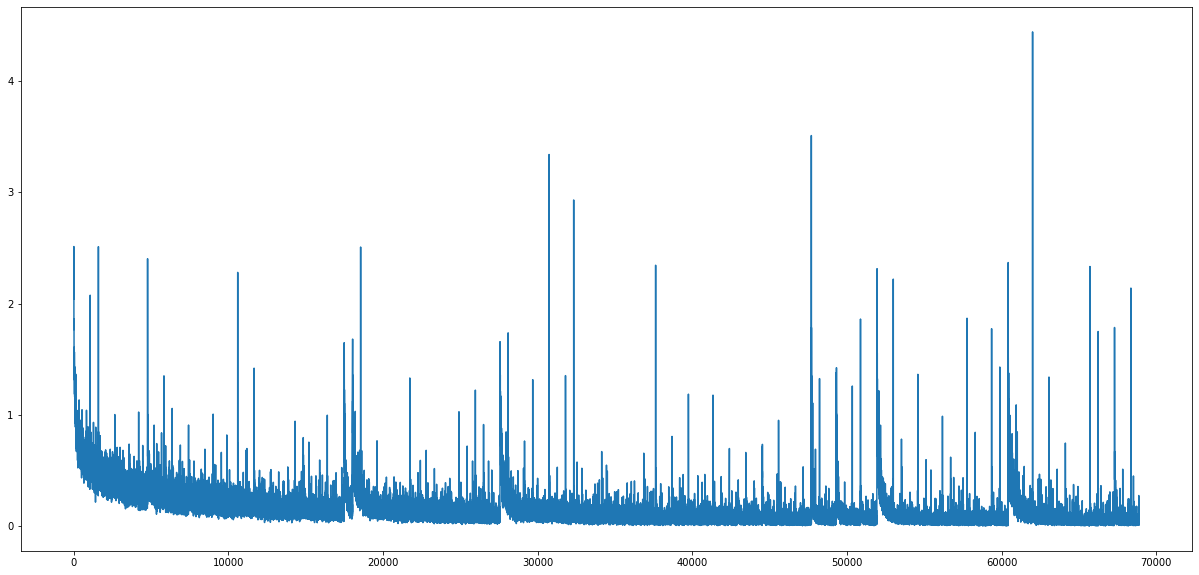

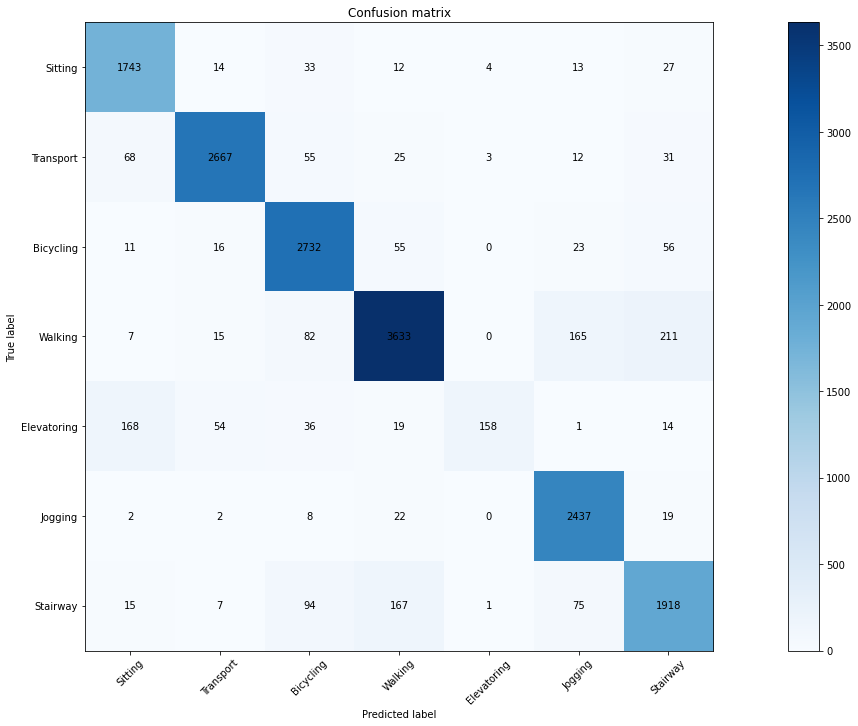

In [ ]:
model = CNN_BN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_2d_2layer_bn.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_2layer_bn"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, "cm": cm}

loss 400.08476835489273
loss 233.15916319191456
loss 162.63873505592346
loss 136.85199829936028
loss 117.52629169821739
loss 97.91094174981117
loss 86.97225555405021
loss 73.76272326335311
loss 85.55735665559769
loss 70.89298609271646
loss 61.1753122061491
loss 54.33371130563319
loss 57.51057946309447
loss 52.18274111114442
loss 40.123768450692296
loss 134.0219004712999
loss 58.0764329507947
loss 41.836867397651076
loss 37.28406367544085
loss 33.343648651614785
loss 39.273381725884974
loss 29.26030406355858
loss 93.07731888629496
loss 34.13826396409422
loss 37.17731294874102
loss 22.558725816663355
loss 19.596527277026325
loss 30.93004904454574
loss 19.926177731715143
loss 20.61339029064402
loss 21.280114162014797
loss 29.470955456141382
loss 51.76457416359335
loss 19.50209303223528
loss 19.318591602146626
loss 20.352709712809883
loss 12.869444491225295
loss 20.44540848361794
loss 29.490265687927604
loss 10.758221925420003
loss 11.608014543366153
loss 22.754637432051823
loss 11.4938221

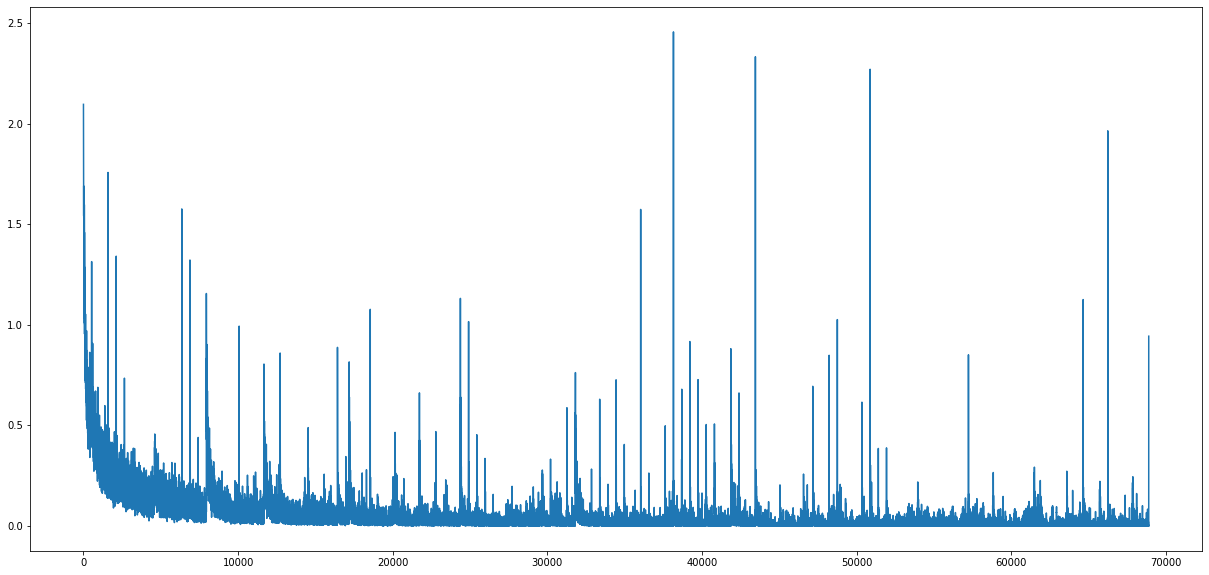

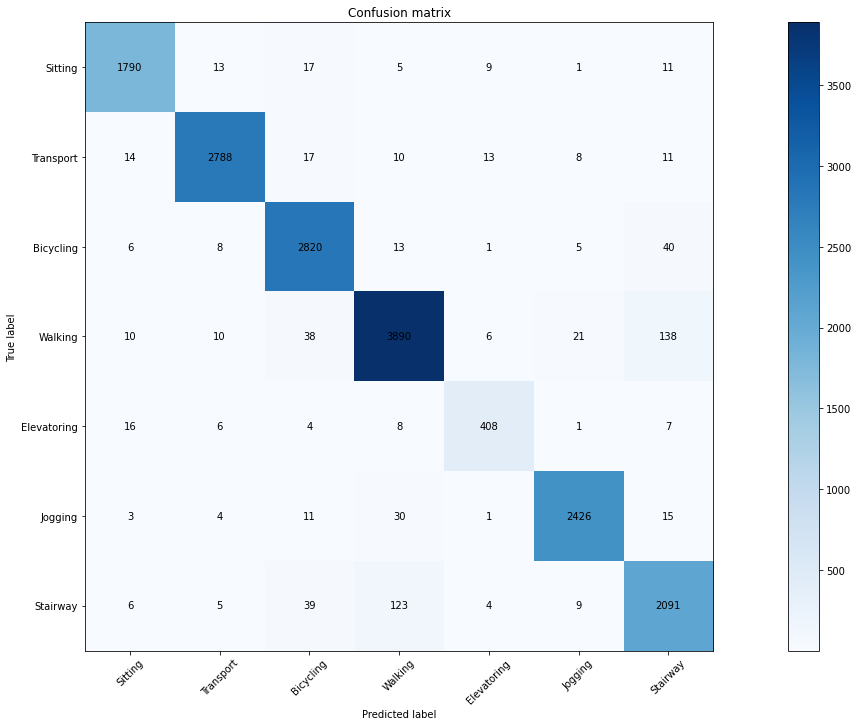

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_2d_2layer.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_2layer"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, "cm": cm}

# Model with 3 convolutional layer

In [ ]:
# define model
class CNN_BN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN_BN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x

# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 426.6583393216133
loss 275.0722132921219
loss 225.85346680879593
loss 199.74197633564472
loss 176.5176564157009
loss 162.6488620340824
loss 146.2781916037202
loss 139.44981851428747
loss 130.21430241316557
loss 140.2990104034543
loss 117.58354718238115
loss 105.26374923810363
loss 98.99357469752431
loss 90.71112234890461
loss 93.29335889592767
loss 92.74152743443847
loss 79.76636547595263
loss 80.0773658156395
loss 80.75891517847776
loss 69.21567918732762
loss 74.199636278674
loss 105.11033123731613
loss 83.74627299979329
loss 57.49832194671035
loss 53.14250507764518
loss 54.244720831513405
loss 100.81858964264393
loss 60.18263706564903
loss 62.03955804929137
loss 58.77406607568264
loss 46.594940442591906
loss 45.73505088407546
loss 46.23089014925063
loss 71.06775652244687
loss 43.441048534587026
loss 40.980318028479815
loss 35.2699313708581
loss 41.580163155682385
loss 36.88179574161768
loss 37.31529079284519
loss 32.687349368818104
loss 38.78833123296499
loss 37.685470580123365


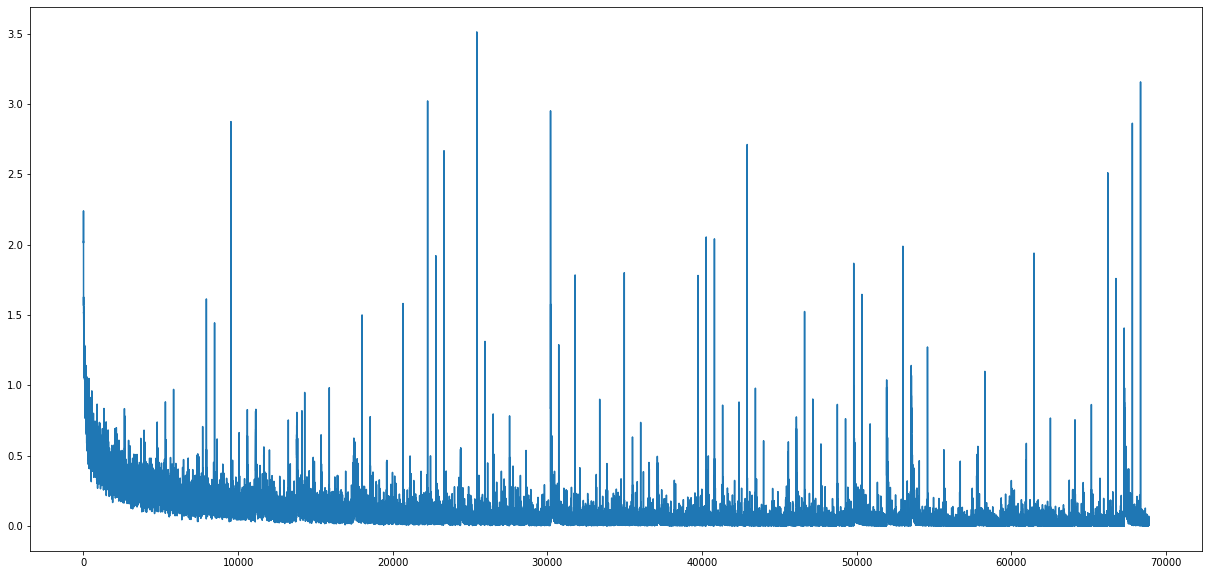

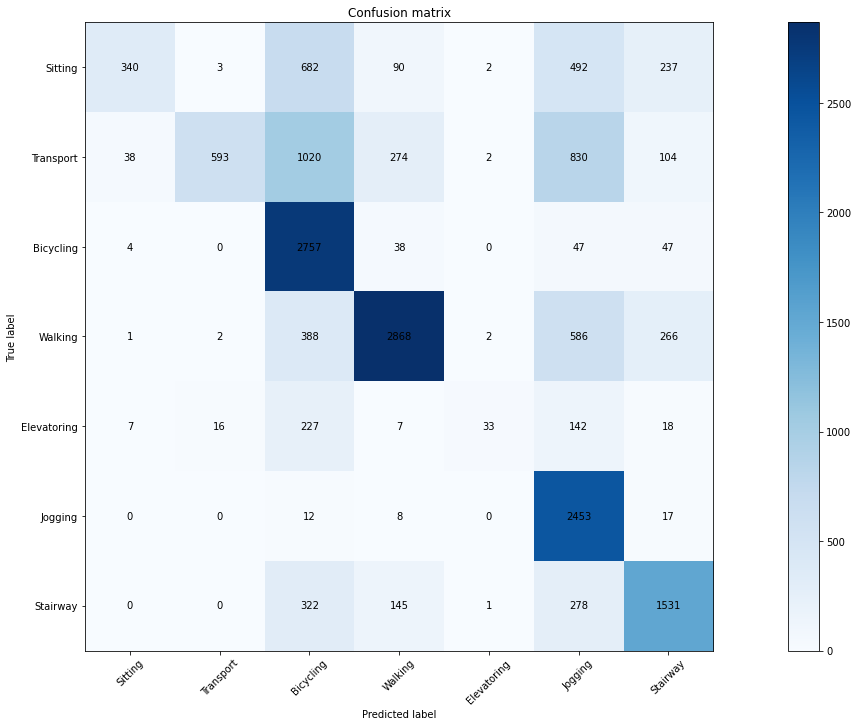

In [ ]:
model = CNN_BN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_3d_2layer_bn.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_3layer_bn"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, "cm": cm}

loss 485.72642639279366
loss 230.77040153741837
loss 168.05018255114555
loss 138.72262443602085
loss 117.18520813435316
loss 124.72738963365555
loss 90.87888748943806
loss 79.81070494279265
loss 68.92532704025507
loss 70.72530146688223
loss 72.90912466868758
loss 52.03581679612398
loss 56.047393719665706
loss 41.885187385603786
loss 41.13755995966494
loss 37.63707510475069
loss 41.00927576422691
loss 32.43435335624963
loss 35.59626758098602
loss 28.45230157347396
loss 80.5149687975645
loss 27.630584462545812
loss 22.68730480596423
loss 17.814001506660134
loss 21.199229432444554
loss 22.559851683909073
loss 18.56121450290084
loss 18.10968685289845
loss 46.548655840568244
loss 40.68932960322127
loss 23.40909931389615
loss 11.837773578357883
loss 8.927099765918683
loss 14.106024038163014
loss 15.094027901766822
loss 15.51766366744414
loss 18.153652662644163
loss 9.568939721561037
loss 14.742732866667211
loss 11.837584638851695
loss 12.707802195160184
loss 12.177265023230575
loss 14.271917

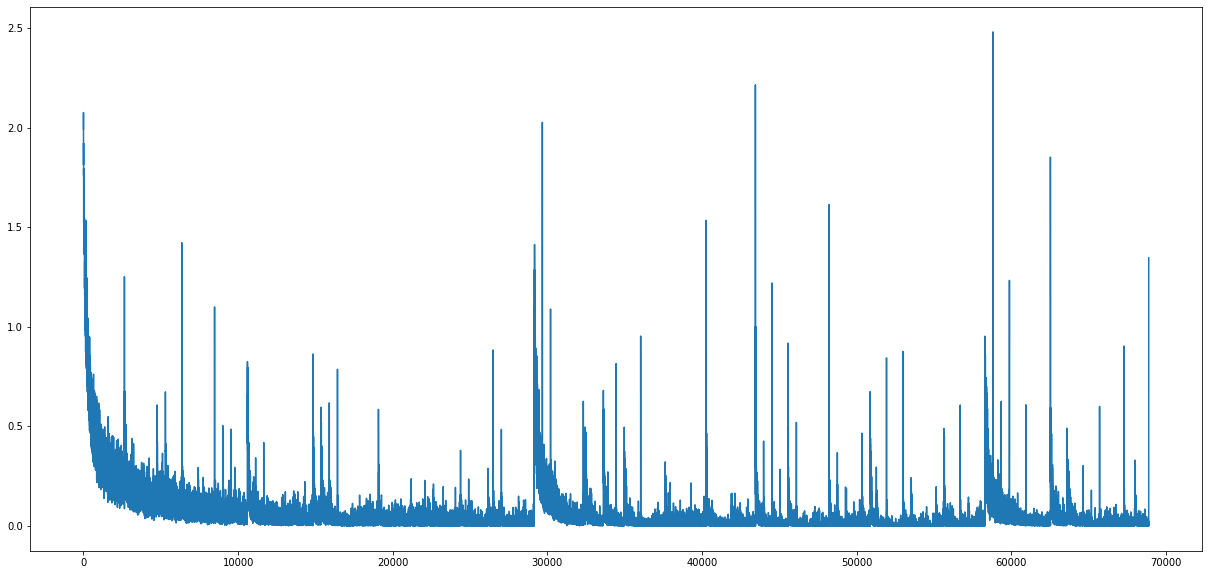

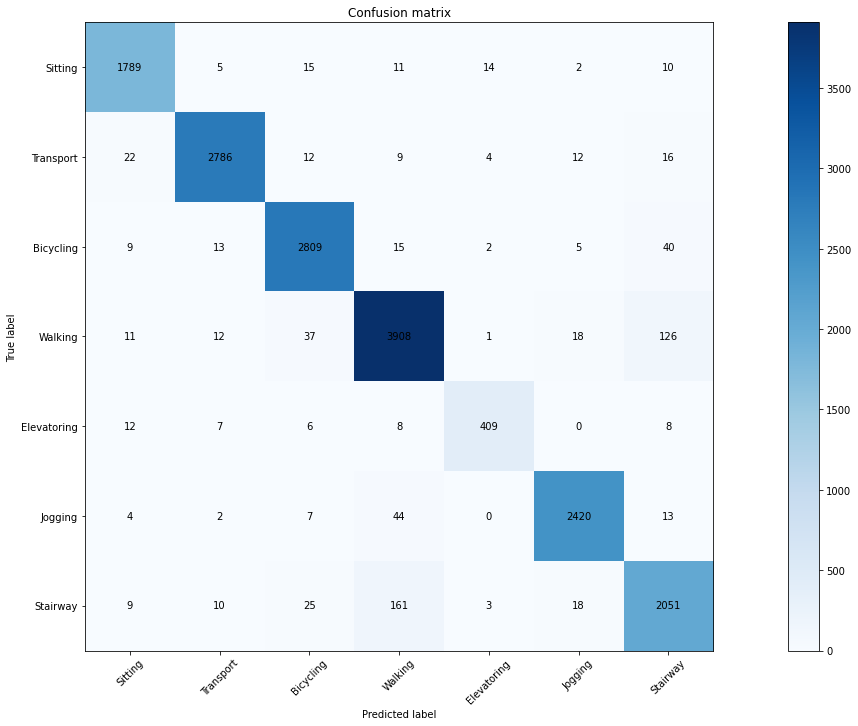

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
torch.save(model.state_dict(), "model_2d_3layer.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results["model_2d_3layer"] = {"accuracy_test": accuracy_test, "accuracy_train": accuracy_train, "f1": f1, "cm": cm}

# CNN with 1D input

In [ ]:
data, target = next(iter(loaderTrain))
assert data[0].flatten().shape[0] == 43 * 13
print(43 * 13)

559


In [ ]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x

# define model
class CNN_BN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN_BN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [ ]:
def train1d(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [ ]:
def evalF1_1D(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [ ]:
def evalTest1D(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))
    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

loss 543.8638442158699
loss 399.016500890255
loss 337.89765897393227
loss 301.144597440958
loss 272.08424493670464
loss 256.53479927778244
loss 243.72671285271645
loss 226.82087856531143
loss 213.71851606667042
loss 199.06222328543663
loss 192.330487459898
loss 201.2473495900631
loss 189.57030038535595
loss 175.01017405092716
loss 182.37562154233456
loss 178.60738730430603
loss 167.43992605805397
loss 159.05168449878693
loss 148.1543836593628
loss 152.27249220758677
loss 146.31137613207102
loss 138.36574845388532
loss 134.95931891351938
loss 133.9567804262042
loss 132.7314828261733
loss 128.24888848513365
loss 130.38145803660154
loss 126.42423854023218
loss 127.63711259514093
loss 118.25209001451731
loss 115.29871229082346
loss 114.68124000355601
loss 109.36236769333482
loss 109.77216809242964
loss 113.12763553950936
loss 101.52858408540487
loss 99.22790313512087
loss 104.48362896591425
loss 103.68460086360574
loss 96.64636206906289
loss 91.63307677954435
loss 99.49004361778498
loss 94

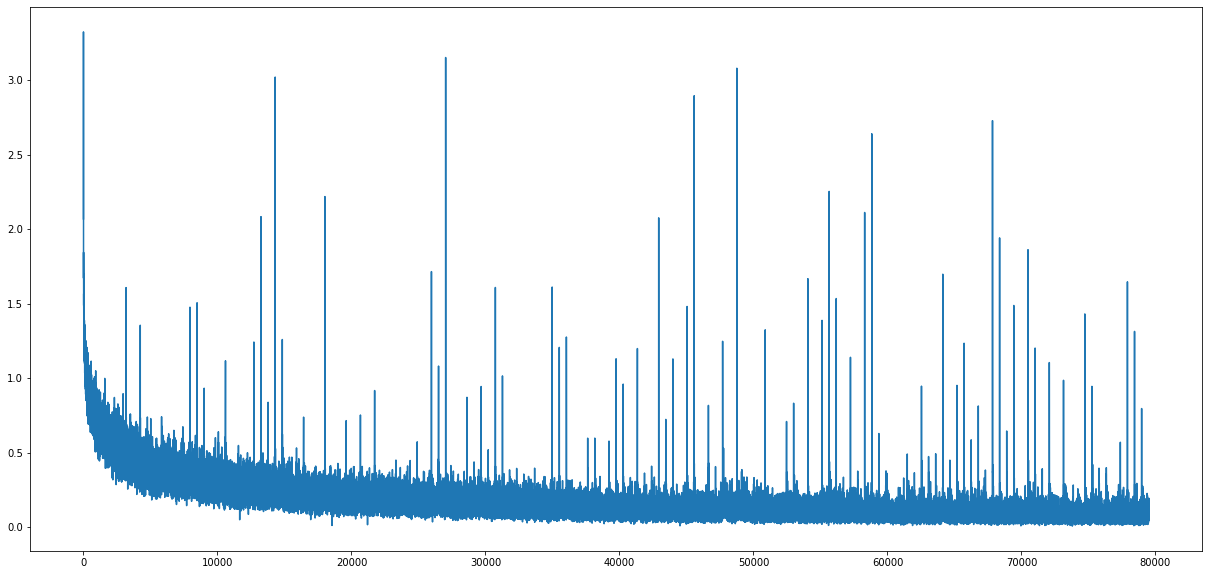

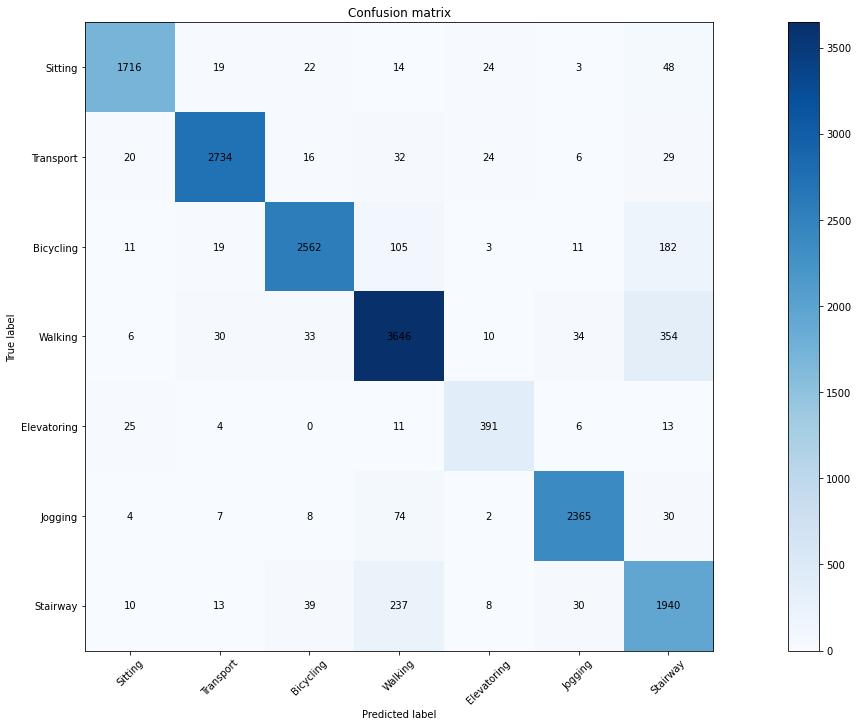

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train1d(model, 150, loaderTrain, torch.optim.Adam(model.parameters(), lr=1e-3), torch.nn.CrossEntropyLoss())
accuracy_test = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
accuracy_train = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
f1 = evalF1_1D(testLoader=loaderTest, model=model)
torch.save(model.state_dict(), "model_1d_1layer.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

results['model_1d_1layer'] = {'accuracy_test': accuracy_test, 'accuracy_train': accuracy_train, 'f1': f1, 'cm': cm}

loss 682.0049740076065
loss 493.38795763254166
loss 440.93718791007996
loss 415.558729827404
loss 388.38648822903633
loss 368.45180690288544
loss 352.37400141358376
loss 342.3640260696411
loss 333.5032508969307
loss 320.3939444720745
loss 304.37558701634407
loss 300.4758407473564
loss 296.4815661609173
loss 283.0163969397545
loss 276.2571931183338
loss 277.1078272610903
loss 273.6091115772724
loss 266.97962057590485
loss 263.9597769677639
loss 257.18985599279404
loss 260.1131497323513
loss 252.58832728862762
loss 246.2761476188898
loss 244.77510368824005
loss 244.9435433447361
loss 236.16997146606445
loss 235.97388251125813
loss 230.33667135238647
loss 228.26678077876568
loss 220.42603988945484
loss 219.9425961971283
loss 217.1275831758976
loss 217.82953292131424
loss 214.42323178052902
loss 214.68600825965405
loss 215.78501357138157
loss 208.26681189239025
loss 204.54034592211246
loss 204.10714523494244
loss 202.54841436445713
loss 202.07264578342438
loss 198.16960956156254
loss 194.0

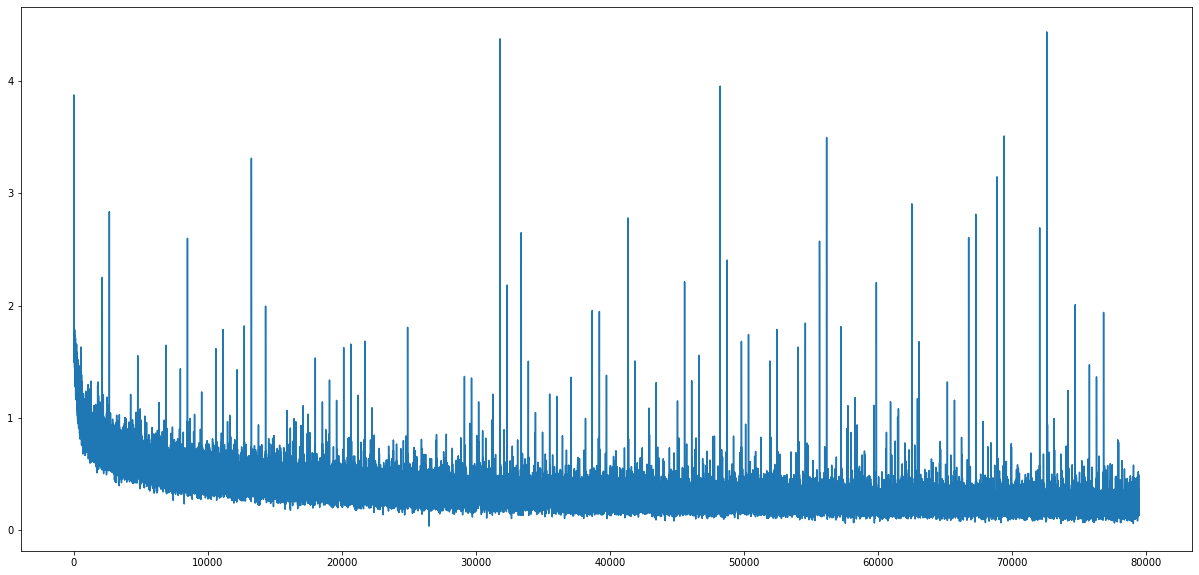

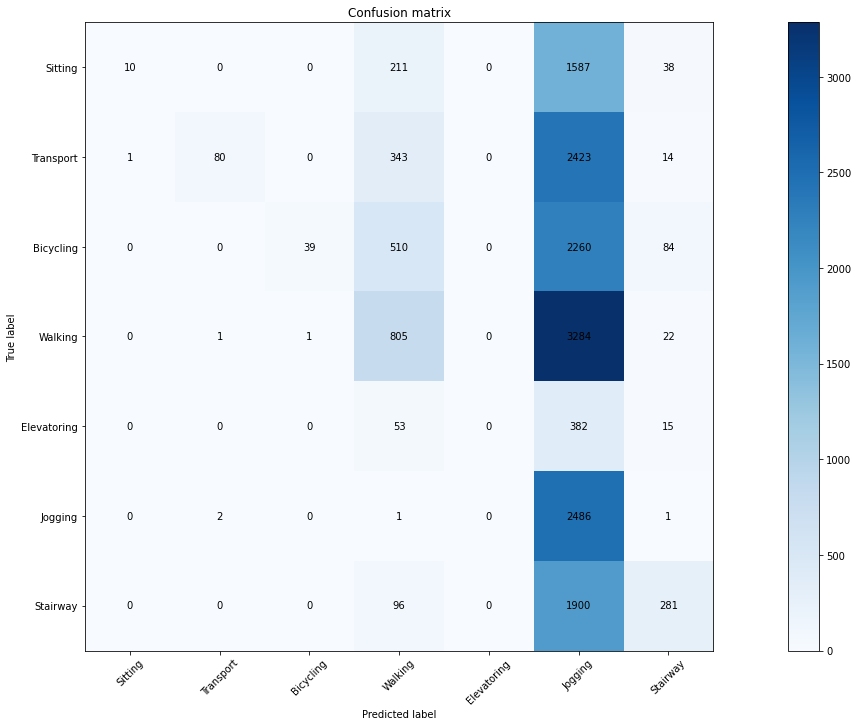

In [ ]:
model = CNN_BN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train1d(model, 150, loaderTrain, torch.optim.Adam(model.parameters(), lr=1e-3), torch.nn.CrossEntropyLoss())
accuracy_test = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
accuracy_train = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
f1 = evalF1_1D(testLoader=loaderTest, model=model)
torch.save(model.state_dict(), "model_1d_1layer_bn.pt")
plt.plot(loss_hist)
plt.show()

cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

results['model_1d_1layer_bn'] = {'accuracy_test': accuracy_test, 'accuracy_train': accuracy_train, 'f1': f1, 'cm': cm}

# Model with three 2D convolutional layers and L2 regularization

In [ ]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


In [ ]:
def trainL2(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [ ]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2(model=model, epochs=250, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1(loaderTest, model)
    f1Scores.append(f1Score)

loss 25961.81837463379
loss 6798.8078989982605
loss 1701.4280230998993
loss 1021.9917769432068
loss 969.8792014122009
loss 961.522610783577
loss 956.4589408636093
loss 951.9263254404068
loss 948.5061385631561
loss 945.9923620223999
loss 944.6539655923843
loss 934.7550152540207
loss 937.4815584421158
loss 929.7385482788086
loss 928.2642896175385
loss 928.0874181985855
loss 923.566592335701
loss 920.582218170166
loss 920.8689918518066
loss 919.0535144805908
loss 919.3023089170456
loss 915.6517045497894
loss 918.1214243173599
loss 915.4470183849335
loss 916.1224403381348
loss 917.8146625757217
loss 914.3893924951553
loss 914.8666342496872
loss 916.7139189243317
loss 913.6916925907135
loss 915.2853928804398
loss 915.2802857160568
loss 914.160572886467
loss 913.984363079071
loss 913.98834836483
loss 914.8272533416748
loss 914.5382615327835
loss 921.3533189296722
loss 914.7369606494904
loss 917.9900224208832
loss 916.0016969442368
loss 914.8184835910797
loss 913.945152759552
loss 913.5804988

Lambda 0.1, Train: 50.74646701811899, Test: 50.0, F1: 0.3281895817261681
Lambda 0.01, Train: 57.02830815576131, Test: 56.18428824571766, F1: 0.407790841955428
Lambda 0.001, Train: 62.93802330217517, Test: 61.6066154754873, F1: 0.47473921807824604
Lambda 0.0001, Train: 75.03359470754145, Test: 72.13821618428824, F1: 0.6158721150099143
Lambda 1e-05, Train: 74.2494720831672, Test: 70.3071470761961, F1: 0.593226332349671


Text(0.5, 1.0, 'Loss vs epoch for different lms')

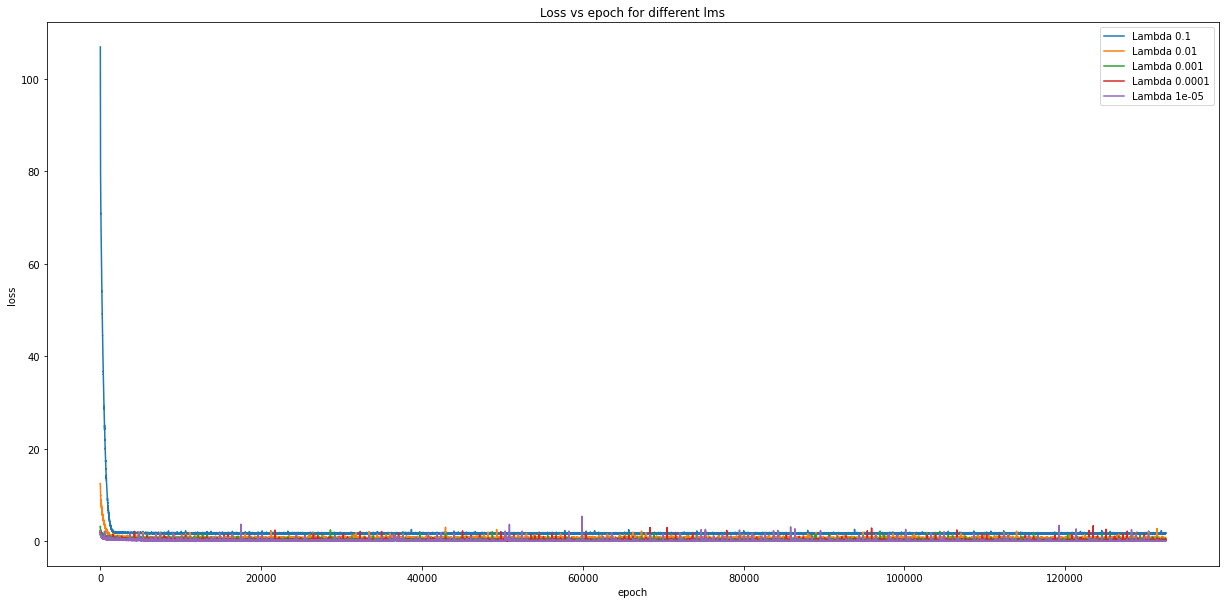

In [ ]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Model with 1D convolution

In [ ]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [ ]:
def trainL2_1D(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs-10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [ ]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2_1D(model=model, epochs=100, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1_1D(loaderTest, model)
    f1Scores.append(f1Score)

loss 73512.35343933105
loss 18853.603118896484
loss 3646.473716020584
loss 1188.7200964689255
loss 990.7707376480103
loss 978.1579608917236
loss 976.7028868198395
loss 975.6518706083298
loss 974.8318215608597
loss 974.0601762533188
loss 973.7275446653366
loss 973.3586000204086
loss 972.9262529611588
loss 971.3974958658218
loss 964.0268890857697
loss 960.8646875619888
loss 960.1009384393692
loss 958.2401666641235
loss 960.5733386278152
loss 958.1718901395798
loss 961.6883537769318
loss 960.7168563604355
loss 961.2104061841965
loss 959.7726112604141
loss 959.2316831350327
loss 960.5282001495361
loss 959.9655278921127
loss 960.6145143508911
loss 959.9989659786224
loss 961.0311876535416
loss 960.5497896671295
loss 960.5664502382278
loss 960.1087574958801
loss 960.7888857126236
loss 959.9971315860748
loss 960.1805679798126
loss 958.4258927106857
loss 961.337183713913
loss 959.6541830301285
loss 961.180425286293
loss 959.6485291719437
loss 961.4128530025482
loss 961.8317031860352
loss 961.34

Lambda 0.1, Train: 40.42144745197064, Test: 40.821027761370345, F1: 0.23007179313752982
Lambda 0.01, Train: 67.02107237259854, Test: 66.69816893089191, F1: 0.578833089358776
Lambda 0.001, Train: 64.6229270957929, Test: 64.03425871234495, F1: 0.5676373863696466
Lambda 0.0001, Train: 82.9338885689393, Test: 81.15770821027762, F1: 0.7718055317997863
Lambda 1e-05, Train: 91.35840753702801, Test: 87.68458357944478, F1: 0.8730085559391104


Text(0.5, 1.0, 'Loss vs epoch for different lms')

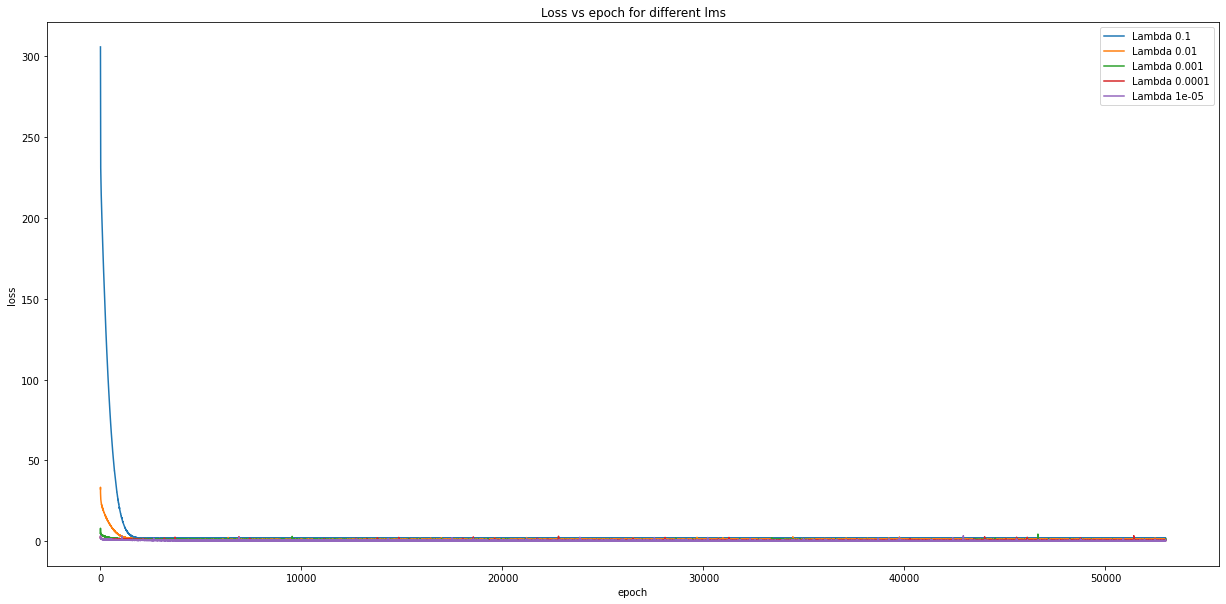

In [ ]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Bestes Modell 1D Input

loss 554.2377794981003
loss 411.8294969201088
loss 358.665436565876
loss 325.92787715792656
loss 304.6751443743706
loss 289.22174739837646
loss 271.65203511714935
loss 259.00346225500107
loss 247.16414496302605
loss 235.93359369039536
loss 222.51146909594536
loss 214.90030959248543
loss 208.00356759130955
loss 197.3169818073511
loss 194.67534157633781
loss 187.8135370463133
loss 191.36070775985718
loss 179.18936747312546
loss 172.1493208706379
loss 170.75339908897877
loss 169.06352411210537
loss 158.36721163988113
loss 162.28361374139786
loss 158.31954623758793
loss 158.32035851478577
loss 154.13446126878262
loss 149.96198301017284
loss 147.84155556559563
loss 142.93349899351597
loss 145.14232508838177
loss 146.336412191391
loss 137.57384999096394
loss 134.53181165456772
loss 134.75150710344315
loss 134.9662932008505
loss 136.1028221398592
loss 138.1165219694376
loss 133.11354609578848
loss 128.02852960675955
loss 126.45775385946035
loss 126.39998733997345
loss 127.19216913729906
loss 

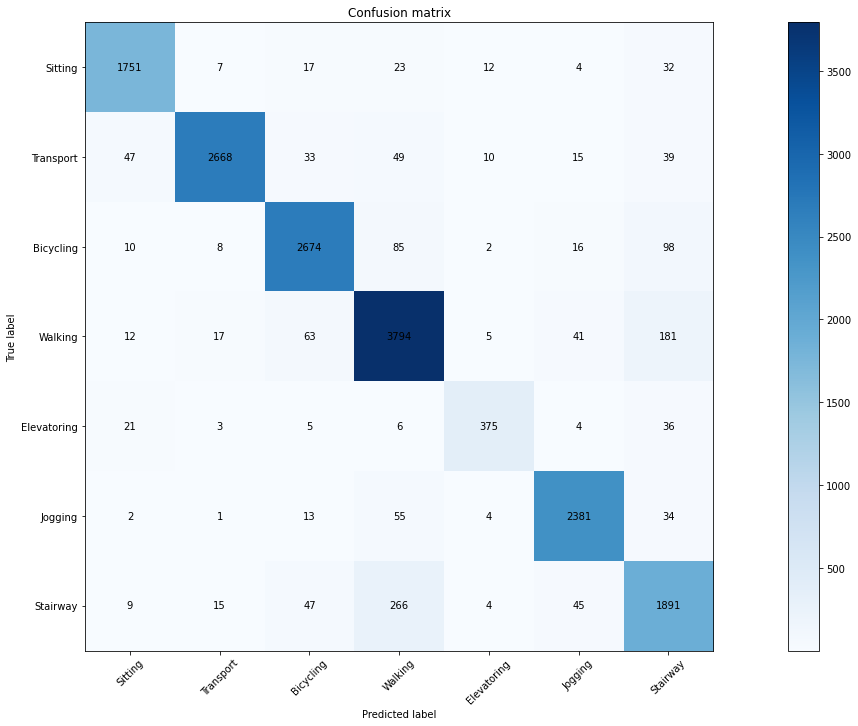

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2_1D(model=model, epochs=300, lm=0.00001,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1Score = evalF1_1D(loaderTest, model)
torch.save(model.state_dict(), "best_model_1D.pt")

cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

results['best_model_1d'] = {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1': f1Score, 'cm': cm}

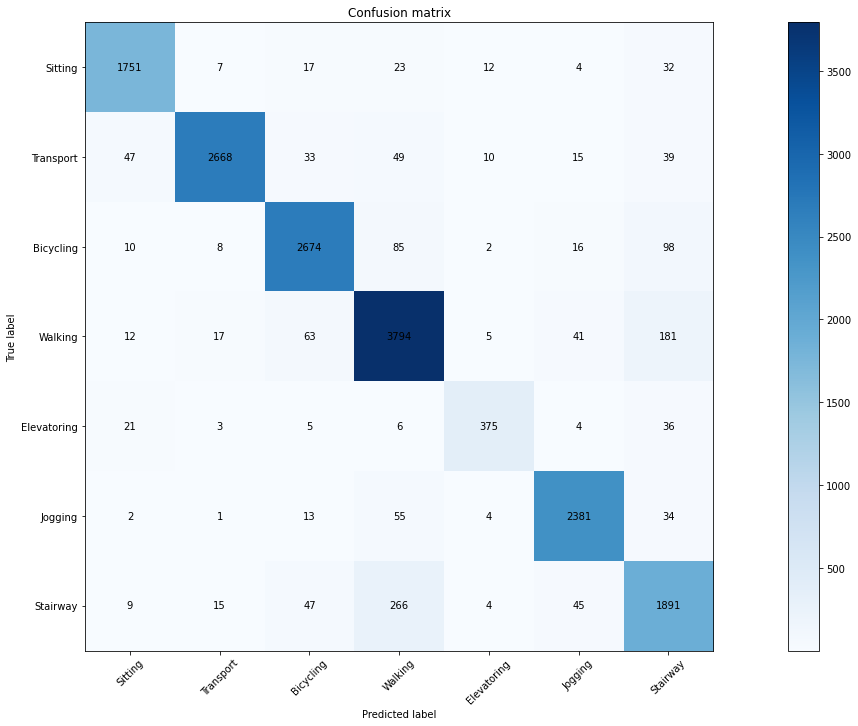

In [ ]:
cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

# Bestes Modell 2D Input

## Modell

In [ ]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=16),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=32),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=64),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),

            torch.nn.Linear(in_features=672, out_features=336),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=336),

            torch.nn.Linear(in_features=336, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 467.0365407168865
loss 270.84109023213387
loss 210.90354177355766
loss 171.0038125216961
loss 147.96918865293264
loss 122.67635236680508
loss 112.021947696805
loss 145.92886887863278
loss 92.58562817424536
loss 93.82139666005969
loss 78.23776489496231
loss 71.5088160019368
loss 68.10323275253177
loss 59.49233631044626
loss 52.12947365641594
loss 50.69658116437495
loss 57.74552481807768
loss 43.292547119781375
loss 41.55085232015699
loss 43.57331911008805
loss 34.48888775520027
loss 35.812771348748356
loss 38.02730467636138
loss 35.979741181246936
loss 38.30252755060792
loss 21.078863768139854
loss 25.448185300687328
loss 24.516279583331198
loss 25.86511658458039
loss 23.733751755207777
loss 60.196246032603085
loss 26.67555971047841
loss 21.656045244075358
loss 16.440960600739345
loss 18.13894916512072
loss 25.198445739020826
loss 21.502499839756638
loss 13.455496425565798
loss 22.71967768180184
loss 20.09438710520044
loss 12.03713137540035
loss 22.38611395395128
loss 11.7007518899

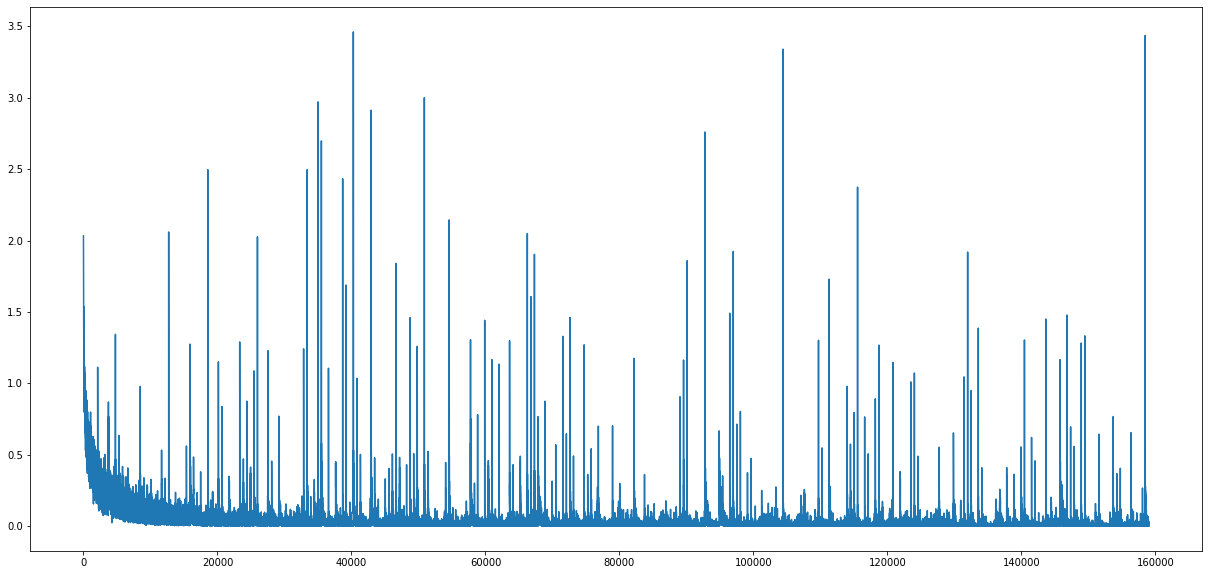

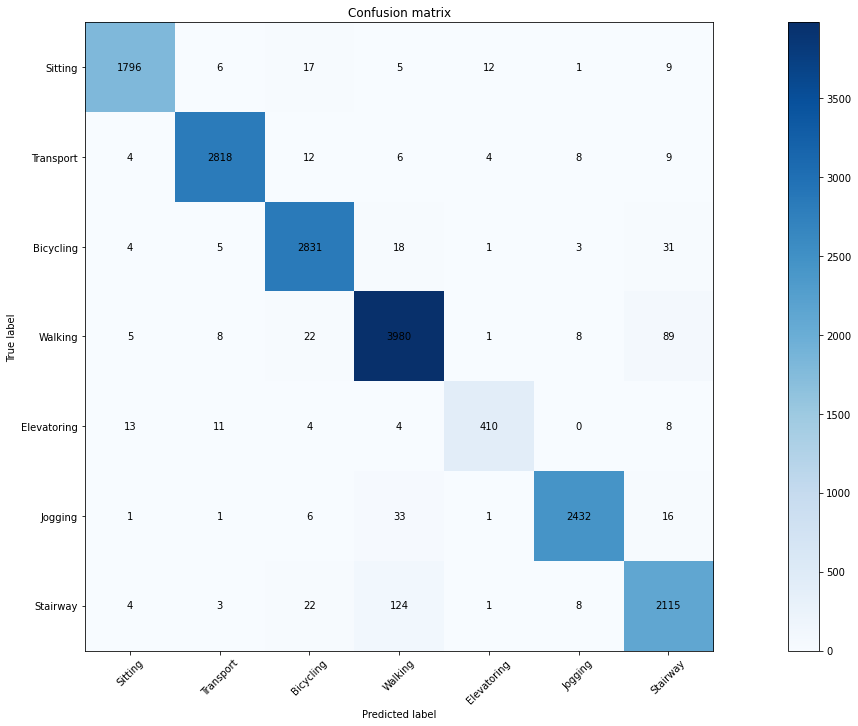

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2(model=model, epochs=300, lm=1e-10,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
plt.plot(loss_hist)
torch.save(model.state_dict(), "best_model_2d.pt")

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

results['best_model_2d'] = {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1': f1}

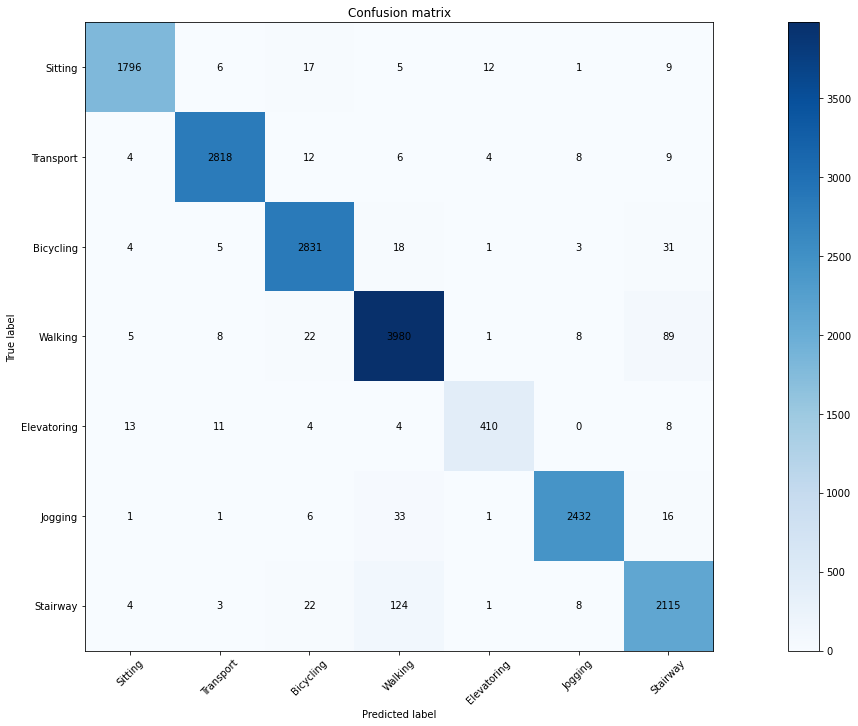

In [ ]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

Dieses Modell ist sehr stark overfitted. Es hat den Trainingsdatensatz fast komplett memorisiert und performt mit einer Genauigkeit von fast 100%. Auf dem Testdatensatz können auch hervorragende Ergebnisse erzielt werden, der höchste Score beträgt 97%. Es ist zu hinterfragen, ob dieses Modell in der Produktion angwendet werden soll. Eine bessere Variante wäre es, die Genauigkeit des Trainings- und des Testdatensatzes anzunähren, um sicherzustellen, dass das Modell nicht zu stark auf den Trainingsdatensatz eingenommen ist. 

In [ ]:
torch.save(model.state_dict(), '97%model.pt')

from google.colab import files

files.download('97%model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

loss 940.8756929636002
loss 512.9035532474518
loss 376.85126677155495
loss 286.5639270544052
loss 252.41949093341827
loss 236.1244457066059
loss 220.0368814766407
loss 207.3406907916069
loss 214.62702430784702
loss 191.49815617501736
loss 191.28066435456276
loss 200.24476516246796
loss 201.08171963691711
loss 226.03156384825706
loss 184.17458586394787
loss 178.2949653416872
loss 181.71200169622898
loss 170.21343472599983
loss 169.67251534759998
loss 170.35368271172047
loss 170.29142178595066
loss 162.49474307894707
loss 168.45145152509212
loss 160.92547909915447
loss 161.0374228209257
loss 164.36685758829117
loss 154.88470055162907
loss 152.74195230007172
loss 163.99040411412716
loss 154.28756774961948
loss 155.08007845282555
loss 155.06106957793236
loss 150.55816319584846
loss 169.64405632019043
loss 148.35061095654964
loss 154.28861410915852
loss 151.3453872948885
loss 156.6338458508253
loss 152.96175339818
loss 146.97285196185112
loss 143.8724798411131
loss 144.75313012301922
loss 1

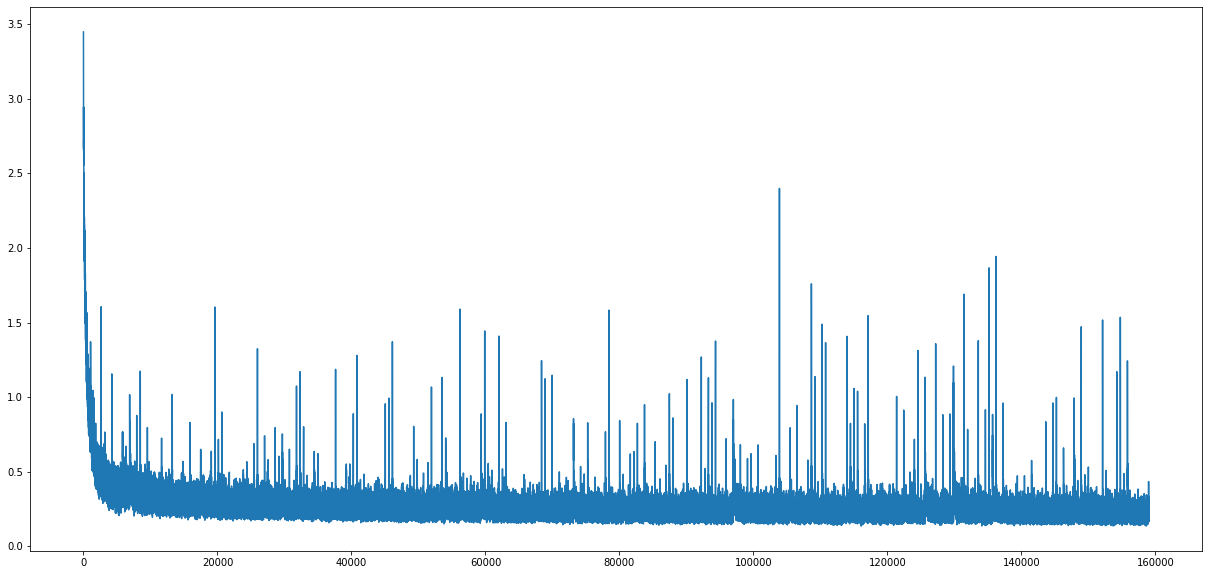

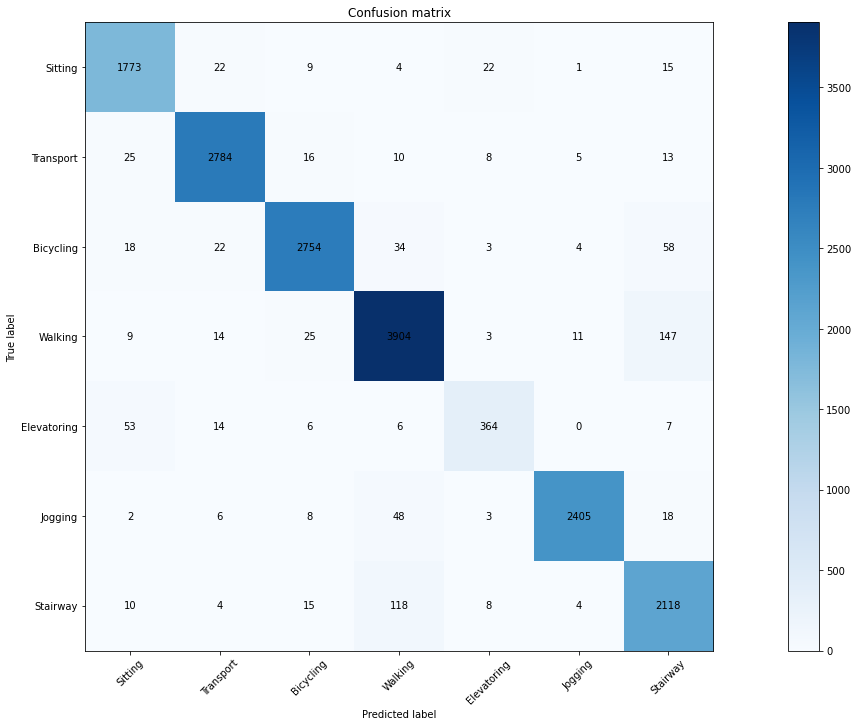

In [ ]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2(model=model, epochs=300, lm=1e-3,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
accuracy_test = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
accuracy_train = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1 = evalF1(loaderTest, model)
plt.plot(loss_hist)

cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

In [ ]:
torch.save(model.state_dict(), '96%model.pt')

from google.colab import files

files.download('96%model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>